**Determining the Relationship between Sexual Harrasment and Child Abuse Occurrences with the Location of the Incidents with Machine Learning Principles (Example of a Case Study in Los Angeles crime arrest data)**

In [1]:
#Taking data from Kaggle
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

chmod: cannot access 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d cityofLA/los-angeles-crime-arrest-data
!ls

los-angeles-crime-arrest-data.zip: Skipping, found more recently modified local copy (use --force to force download)
los-angeles-crime-arrest-data.zip  sample_data


**Library**

In [3]:
import pandas as pd
import pandas as np
from zipfile import ZipFile
import re
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import folium
from folium.plugins import FastMarkerCluster
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pathlib

**Open Data**

In [4]:
with ZipFile("los-angeles-crime-arrest-data.zip") as myzip:
    data = myzip.open("crime-data-from-2010-to-present.csv")
#Read data file
df = pd.read_csv(data)

**Processing Data**

In [5]:
#Sorting data specifically for sexual violence and child abuse
df = df[df['Victim Age'].notna()]
df = df[df['Victim Sex'].notna()]
# LEWD|RAPE|SEX|SEXUAL|ABUSE|ABANDONMENT|COPULATION|MINOR
df = df[df['Crime Code Description'].str.contains("LEWD|RAPE|SEX|SEXUAL|ABUSE|ABANDONMENT|COPULATION")]
#See data
df.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Weapon Used Code,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location
276,111108944,2011-04-05T00:00:00,2010-11-01T00:00:00,1800,11,Northeast,1173,956,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",NaN,52,F,H,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AO,Adult Other,956.0,NaN,NaN,NaN,2100 EWING ST,NaN,"{'latitude': '34.0897', 'needs_recoding': Fals..."
284,172111385,2017-05-19T00:00:00,2010-01-01T00:00:00,1200,21,Topanga,2177,121,"RAPE, FORCIBLE",2000 0519 1813,22,F,W,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,121.0,NaN,NaN,NaN,21500 CALIFA ST,NaN,"{'latitude': '34.1773', 'needs_recoding': Fals..."
586,101016854,2010-09-20T00:00:00,2010-09-19T00:00:00,1900,10,West Valley,1039,762,LEWD CONDUCT,0528,20,F,H,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont,762.0,NaN,NaN,NaN,HASKELL,VANOWEN,"{'latitude': '34.1939', 'needs_recoding': Fals..."
590,101019120,2010-11-03T00:00:00,2010-11-03T00:00:00,1345,10,West Valley,1001,762,LEWD CONDUCT,NaN,27,F,A,203.0,OTHER BUSINESS,NaN,NaN,IC,Invest Cont,762.0,NaN,NaN,NaN,7600 TAMPA AV,NaN,"{'latitude': '34.2084', 'needs_recoding': Fals..."
700,101513551,2010-06-02T00:00:00,2010-05-28T00:00:00,1200,15,N Hollywood,1549,956,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",1259,17,F,H,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont,956.0,NaN,NaN,NaN,5500 VINELAND AV,NaN,"{'latitude': '34.17', 'needs_recoding': False,..."


In [6]:
#Processing data location
geoloc_list = df.iloc[:, [0, -1]].values.tolist()
arr = []

for val in geoloc_list:
  lat = re.search(r'(?:\'latitude\'\: )(\'[0-9\.\-]+\')', val[1])
  long = re.search(r'(?:\'longitude\'\: )(\'[0-9\.\-]+\')', val[1])
  arr.append([val[0], lat[1].strip('\''), long[1].strip('\'')])

df_geoloc = pd.DataFrame(arr, columns =['DR Number', 'Latitude', 'Longitude'], dtype = float)
df_geoloc.iloc[:, [1, 2]].values.tolist()

#Merge location data back
merged = pd.merge(df, df_geoloc, on="DR Number")
merged = merged[ merged['Latitude'] > 0.0]

In [7]:
#Separate date
list_tgl = df[["DR Number", "Date Occurred"]].values.tolist()
arr_temp_tgl = []

for val in list_tgl:
  dr = val[0]
  tgl = val[1].split('T')[0]
  tgl_split = tgl.split('-')
  tahun = tgl_split[0]
  bulan = tgl_split[1]
  hari = tgl_split[2]

  arr_temp_tgl.append([dr, tgl, tahun, bulan, hari])

df_date = pd.DataFrame(arr_temp_tgl, columns =['DR Number', 'Full date', 'Year', 'Month', 'Day'], dtype = int)

#Merge back to df
merge_tgl = pd.merge(merged, df_date, on="DR Number")

#Checks the data types of all columns in the data frame
merge_tgl.dtypes

DR Number                   int64
Date Reported              object
Date Occurred              object
Time Occurred               int64
Area ID                     int64
Area Name                  object
Reporting District          int64
Crime Code                  int64
Crime Code Description     object
MO Codes                   object
Victim Age                  int64
Victim Sex                 object
Victim Descent             object
Premise Code              float64
Premise Description        object
Weapon Used Code          float64
Weapon Description         object
Status Code                object
Status Description         object
Crime Code 1              float64
Crime Code 2              float64
Crime Code 3              float64
Crime Code 4              float64
Address                    object
Cross Street               object
Location                   object
Latitude                  float64
Longitude                 float64
Full date                  object
Year          

In [8]:
#Check Gender
merge_tgl["Victim Sex"].value_counts()

#Delete another weird gender like H and X
merge_tgl= merge_tgl[~merge_tgl['Victim Sex'].str.contains('X|H')]

In [9]:
#Convert data to numeric
merge_tgl['Year'] = merge_tgl['Year'].apply(pd.to_numeric, errors='coerce')
merge_tgl['Month'] = merge_tgl['Month'].apply(pd.to_numeric, errors='coerce')
merge_tgl['Day'] = merge_tgl['Day'].apply(pd.to_numeric, errors='coerce')
merge_tgl['Latitude'] = merge_tgl['Latitude'].apply(pd.to_numeric, errors='coerce')
merge_tgl['Longitude'] = merge_tgl['Longitude'].apply(pd.to_numeric, errors='coerce')

#Labeling data
LE = LabelEncoder()
merge_tgl['Date Occurred Code'] = LE.fit_transform(merge_tgl['Date Occurred'])
merge_tgl['Crime Code(SH&CA)'] = LE.fit_transform(merge_tgl['Crime Code Description']) 
merge_tgl['Victim Sex Code'] = LE.fit_transform(merge_tgl['Victim Sex'])
merge_tgl['Victim Descent Code'] = LE.fit_transform(merge_tgl['Victim Descent'].astype(str))
merge_tgl['Premise Description Code'] = LE.fit_transform(merge_tgl['Premise Description'].astype(str))
merge_tgl['Address Code'] = LE.fit_transform(merge_tgl['Address'])

merge_tgl.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Weapon Used Code,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location,Latitude,Longitude,Full date,Year,Month,Day,Date Occurred Code,Crime Code(SH&CA),Victim Sex Code,Victim Descent Code,Premise Description Code,Address Code
0,111108944,2011-04-05T00:00:00,2010-11-01T00:00:00,1800,11,Northeast,1173,956,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",NaN,52,F,H,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AO,Adult Other,956.0,NaN,NaN,NaN,2100 EWING ST,NaN,"{'latitude': '34.0897', 'needs_recoding': Fals...",34.0897,-118.2561,2010-11-01,2010,11,1,304,7,0,6,194,9624
1,172111385,2017-05-19T00:00:00,2010-01-01T00:00:00,1200,21,Topanga,2177,121,"RAPE, FORCIBLE",2000 0519 1813,22,F,W,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,121.0,NaN,NaN,NaN,21500 CALIFA ST,NaN,"{'latitude': '34.1773', 'needs_recoding': Fals...",34.1773,-118.5988,2010-01-01,2010,1,1,0,12,0,16,194,9859
2,101016854,2010-09-20T00:00:00,2010-09-19T00:00:00,1900,10,West Valley,1039,762,LEWD CONDUCT,0528,20,F,H,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont,762.0,NaN,NaN,NaN,HASKELL,VANOWEN,"{'latitude': '34.1939', 'needs_recoding': Fals...",34.1939,-118.4749,2010-09-19,2010,9,19,261,8,0,6,169,22648
3,101019120,2010-11-03T00:00:00,2010-11-03T00:00:00,1345,10,West Valley,1001,762,LEWD CONDUCT,NaN,27,F,A,203.0,OTHER BUSINESS,NaN,NaN,IC,Invest Cont,762.0,NaN,NaN,NaN,7600 TAMPA AV,NaN,"{'latitude': '34.2084', 'needs_recoding': Fals...",34.2084,-118.5535,2010-11-03,2010,11,3,306,8,0,0,160,19202
4,101513551,2010-06-02T00:00:00,2010-05-28T00:00:00,1200,15,N Hollywood,1549,956,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",1259,17,F,H,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont,956.0,NaN,NaN,NaN,5500 VINELAND AV,NaN,"{'latitude': '34.17', 'needs_recoding': False,...",34.1700,-118.3703,2010-05-28,2010,5,28,147,7,0,6,77,16042


In [10]:
import datetime
convert_date_format=pd.to_datetime(merge_tgl["Full date"], errors='coerce')
date=pd.DataFrame({"Day of Week": convert_date_format.dt.dayofweek,
              "Quarter": convert_date_format.dt.quarter})

In [11]:
merge_tgl=pd.concat([merge_tgl,date],axis=1)
merge_tgl

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Weapon Used Code,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location,Latitude,Longitude,Full date,Year,Month,Day,Date Occurred Code,Crime Code(SH&CA),Victim Sex Code,Victim Descent Code,Premise Description Code,Address Code,Day of Week,Quarter
0,111108944,2011-04-05T00:00:00,2010-11-01T00:00:00,1800,11,Northeast,1173,956,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",NaN,52,F,H,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AO,Adult Other,956.0,NaN,NaN,NaN,2100 EWING ST,NaN,"{'latitude': '34.0897', 'needs_recoding': Fals...",34.0897,-118.2561,2010-11-01,2010,11,1,304,7,0,6,194,9624,0,4
1,172111385,2017-05-19T00:00:00,2010-01-01T00:00:00,1200,21,Topanga,2177,121,"RAPE, FORCIBLE",2000 0519 1813,22,F,W,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,121.0,NaN,NaN,NaN,21500 CALIFA ST,NaN,"{'latitude': '34.1773', 'needs_recoding': Fals...",34.1773,-118.5988,2010-01-01,2010,1,1,0,12,0,16,194,9859,4,1
2,101016854,2010-09-20T00:00:00,2010-09-19T00:00:00,1900,10,West Valley,1039,762,LEWD CONDUCT,0528,20,F,H,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont,762.0,NaN,NaN,NaN,HASKELL,VANOWEN,"{'latitude': '34.1939', 'needs_recoding': Fals...",34.1939,-118.4749,2010-09-19,2010,9,19,261,8,0,6,169,22648,6,3
3,101019120,2010-11-03T00:00:00,2010-11-03T00:00:00,1345,10,West Valley,1001,762,LEWD CONDUCT,NaN,27,F,A,203.0,OTHER BUSINESS,NaN,NaN,IC,Invest Cont,762.0,NaN,NaN,NaN,7600 TAMPA AV,NaN,"{'latitude': '34.2084', 'needs_recoding': Fals...",34.2084,-118.5535,2010-11-03,2010,11,3,306,8,0,0,160,19202,2,4
4,101513551,2010-06-02T00:00:00,2010-05-28T00:00:00,1200,15,N Hollywood,1549,956,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",1259,17,F,H,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont,956.0,NaN,NaN,NaN,5500 VINELAND AV,NaN,"{'latitude': '34.17', 'needs_recoding': False,...",34.1700,-118.3703,2010-05-28,2010,5,28,147,7,0,6,77,16042,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62809,192111604,6182019-01-01T00:00:00,2019-06-14T00:00:00,1045,21,Topanga,2144,956,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",1906,26,F,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,956.0,NaN,NaN,NaN,6700 SHOUP AV,NaN,"{'latitude': '34.1885', 'needs_recoding': Fals...",34.1885,-118.6190,2019-06-14,2019,6,14,3451,7,0,1,194,17880,4,2
62810,192111649,6182019-01-01T00:00:00,2019-06-17T00:00:00,2040,21,Topanga,2102,956,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",1501,55,F,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,956.0,NaN,NaN,NaN,8800 HILLCROFT TL,NaN,"{'latitude': '34.2242', 'needs_recoding': Fals...",34.2242,-118.6301,2019-06-17,2019,6,17,3454,7,0,16,194,20748,0,2
62811,192111693,6192019-01-01T00:00:00,2019-06-13T00:00:00,5,21,Topanga,2177,121,"RAPE, FORCIBLE",NaN,34,F,W,503.0,HOTEL,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,121.0,NaN,NaN,NaN,21800 OXNARD ST,NaN,"{'latitude': '34.1792', 'needs_recoding': Fals...",34.1792,-118.6030,2019-06-13,2019,6,13,3450,12,0,16,81,9912,3,2
62812,192111790,6212019-01-01T00:00:00,2019-06-21T00:00:00,1700,21,Topanga,2143,815,SEXUAL PENETRATION W/FOREIGN OBJECT,0421 0507 1402,22,F,W,122.0,"VEHICLE, PASSENGER/TRUCK",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,815.0,998.0,NaN,NaN,23000 VICTORY BL,NaN,"{'latitude': '34.1865', 'needs_recoding': Fals...",34.1865,-118.6277,2019-06-21,2019,6,21,3458,14,0,16,231,10493,4,2


In [12]:
#Age more than 0
fix_data = merge_tgl[ merge_tgl['Victim Age'] > 0.0]

#Used Data
fix_data = fix_data[['Year','Month', 'Day', 'Day of Week', 'Quarter', 'Time Occurred', 'Victim Age','Victim Sex Code', 'Victim Descent Code' , 'Premise Description Code', 'Address Code', 'Latitude',	'Longitude','Crime Code(SH&CA)']]

#Drop NAN
fix_data = fix_data.dropna()

fix_data.head()

,Year,Month,Day,Day of Week,Quarter,Time Occurred,Victim Age,Victim Sex Code,Victim Descent Code,Premise Description Code,Address Code,Latitude,Longitude,Crime Code(SH&CA)
0,2010,11,1,0,4,1800,52,0,6,194,9624,34.0897,-118.2561,7
1,2010,1,1,4,1,1200,22,0,16,194,9859,34.1773,-118.5988,12
2,2010,9,19,6,3,1900,20,0,6,169,22648,34.1939,-118.4749,8
3,2010,11,3,2,4,1345,27,0,0,160,19202,34.2084,-118.5535,8
4,2010,5,28,4,2,1200,17,0,6,77,16042,34.1700,-118.3703,7


Delete outlier data to improve quality of data

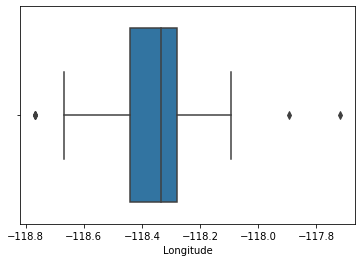

In [13]:
#Check one outlier data to improve quality of data(for example check Longitude)
sns.boxplot(x=fix_data['Longitude'])

In [14]:
#Z-score
z = np.abs(stats.zscore(fix_data))
print(z)

[[1.52533378 1.39661012 1.40687497 ... 0.0246531  0.99140488 0.01954415]
 [1.52533378 1.51667672 1.40687497 ... 0.78732377 2.19835095 1.09791361]
 [1.52533378 0.81395276 0.51628044 ... 0.93184812 1.04512438 0.2039474 ]
 ...
 [1.72207293 0.0600333  0.12477136 ... 0.80386571 2.23744338 1.09791361]
 [1.72207293 0.0600333  0.72996437 ... 0.8674216  2.46734407 1.54489672]
 [1.72207293 0.0600333  0.72996437 ... 0.86655097 2.42732088 0.01954415]]


In [15]:
#Define outlier

# Position of the outlier
threshold = 3
print(np.where(z > 3))

(array([   34,    38,    72, ..., 61199, 61204, 61231]), array([6, 9, 9, ..., 9, 6, 9]))


In [16]:
#Check outlier Spesific 
print(z[34][6])

3.020369279154042


In [17]:
#IQR (detect outlier)
Q1 = fix_data.quantile(0.25)
Q3 = fix_data.quantile(0.75)
IQR = Q3 - Q1

print(IQR)

Year                            5.0000
Month                           6.0000
Day                            16.0000
Day of Week                     4.0000
Quarter                         2.0000
Time Occurred                1000.0000
Victim Age                     22.0000
Victim Sex Code                 0.0000
Victim Descent Code             5.0000
Premise Description Code       42.0000
Address Code                12316.0000
Latitude                        0.1685
Longitude                       0.1626
Crime Code(SH&CA)               8.0000
dtype: float64


In [18]:
# Detect outlier ("True" represent the presence of the outlier)
pd.DataFrame(fix_data < (Q1 - 1.5 * IQR)) |(fix_data > (Q3 + 1.5 * IQR))

,Year,Month,Day,Day of Week,Quarter,Time Occurred,Victim Age,Victim Sex Code,Victim Descent Code,Premise Description Code,Address Code,Latitude,Longitude,Crime Code(SH&CA)
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62809,False,False,False,False,False,False,False,False,False,False,False,False,False,False
62810,False,False,False,False,False,False,False,False,False,False,False,False,False,False
62811,False,False,False,False,False,False,False,False,False,True,False,False,False,False
62812,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [19]:
#Fixing outlier based z score
fix_data = fix_data[(z < 3).all(axis=1)]
print(fix_data.shape)

(58596, 14)


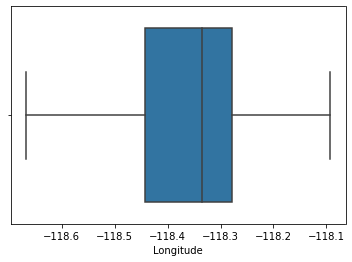

In [20]:
#Check again outlier data, it deleted or not(for example check Longitude)
sns.boxplot(x=fix_data['Longitude'])

**Plot Histograms**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3747: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


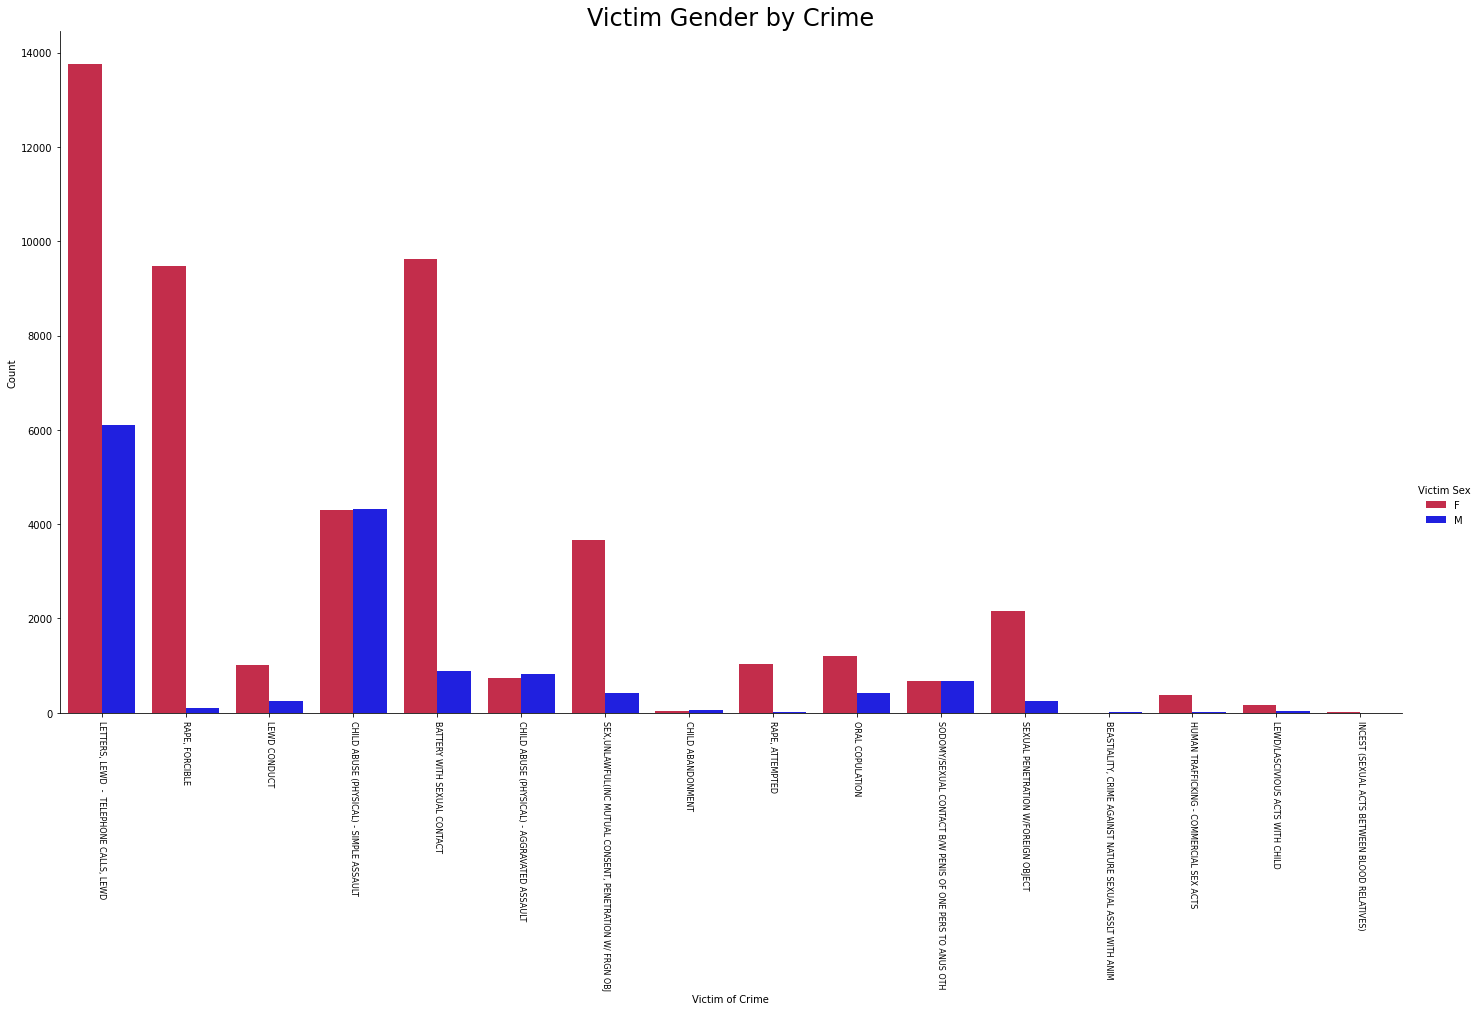

In [21]:
# Plot Crime by Gender (based  count)
ax = sns.catplot(x="Crime Code Description", hue="Victim Sex", data=merge_tgl, kind="count", size=10, aspect=2, palette=["crimson", "blue"])

ax.set_xlabels(("Victim of Crime"))
ax.set_ylabels("Count")
plt.title(("Victim Gender by Crime"), size=24)
ax.set_xticklabels(rotation=-90, size=8)
sns.despine()

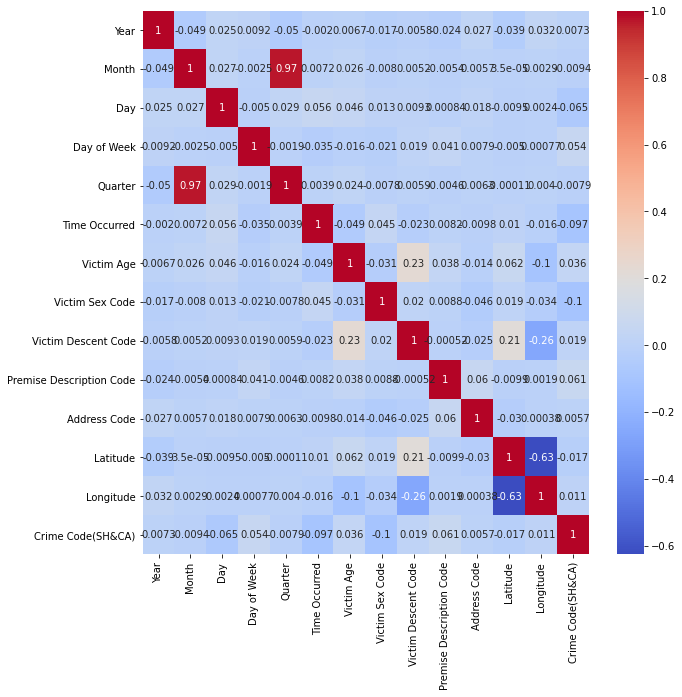

In [22]:
# Heatmap
plt.figure(figsize=(10,10))
_ = sns.heatmap(fix_data.corr(), cmap='coolwarm', annot=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


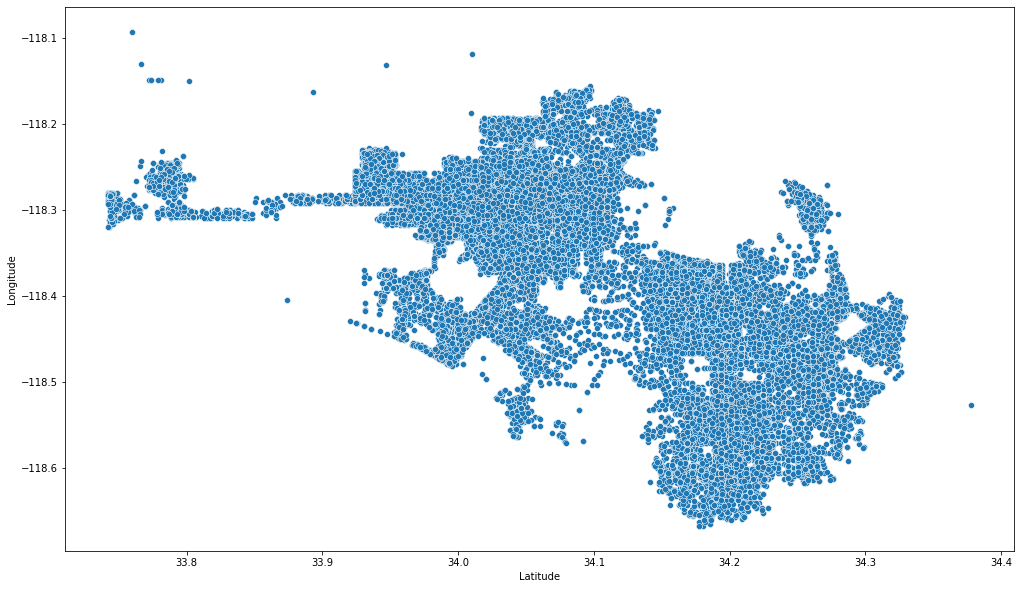

In [23]:
# Plot distribution of victims based on Latitude and Longitude
plt.figure(figsize = (17,10))
sns.scatterplot(fix_data['Latitude'], fix_data['Longitude'])

In [24]:
#Plot to actual map (Los Angeles)
map_pickup = folium.Map( location=[34.052235, -118.243683])
map_pickup.add_child(FastMarkerCluster(fix_data.iloc[:, [11, 12]].values.tolist()))

**Machine Learning (Neural Network)**

In [25]:
#Choose FEATURE and TARGET
FEATURES = fix_data.columns.values[:-1]
TARGET = fix_data.columns.values[13:]
FEATURES, TARGET

(array(['Year', 'Month', 'Day', 'Day of Week', 'Quarter', 'Time Occurred',
        'Victim Age', 'Victim Sex Code', 'Victim Descent Code',
        'Premise Description Code', 'Address Code', 'Latitude',
        'Longitude'], dtype=object),
 array(['Crime Code(SH&CA)'], dtype=object))

In [26]:
#Normalization data (improve training data)
fix_data.loc[:, FEATURES] = ((fix_data[FEATURES] - fix_data[FEATURES].min()) / (fix_data[FEATURES].max() - fix_data[FEATURES].min()))

fix_data.describe()

,Year,Month,Day,Day of Week,Quarter,Time Occurred,Victim Age,Victim Sex Code,Victim Descent Code,Premise Description Code,Address Code,Latitude,Longitude,Crime Code(SH&CA)
count,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000
mean,0.468625,0.473346,0.438077,0.499206,0.470607,0.533178,0.336299,0.221176,0.400017,0.659944,0.526295,0.549771,0.529153,7.081081
std,0.307955,0.312044,0.312315,0.335530,0.370319,0.282674,0.209212,0.415042,0.280529,0.184829,0.295498,0.171237,0.187289,4.460910
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.181818,0.166667,0.166667,0.000000,0.338846,0.178082,0.000000,0.315789,0.572139,0.265270,0.439547,0.390323,4.000000
50%,0.444444,0.454545,0.433333,0.500000,0.333333,0.527566,0.287671,0.000000,0.315789,0.776119,0.545041,0.516373,0.578160,7.000000
75%,0.777778,0.727273,0.700000,0.833333,0.666667,0.762935,0.465753,0.000000,0.578947,0.781095,0.782676,0.701039,0.676056,12.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000


In [27]:
fix_data.head()

,Year,Month,Day,Day of Week,Quarter,Time Occurred,Victim Age,Victim Sex Code,Victim Descent Code,Premise Description Code,Address Code,Latitude,Longitude,Crime Code(SH&CA)
0,0.0,0.909091,0.000000,0.000000,1.000000,0.762935,0.684932,0.0,0.315789,0.781095,0.405119,0.546914,0.715702,7
1,0.0,0.000000,0.000000,0.666667,0.000000,0.508482,0.273973,0.0,0.842105,0.781095,0.415011,0.684824,0.119805,12
2,0.0,0.727273,0.600000,1.000000,0.666667,0.805344,0.246575,0.0,0.315789,0.656716,0.953359,0.710957,0.335246,8
3,0.0,0.909091,0.066667,0.333333,1.000000,0.569975,0.342466,0.0,0.000000,0.611940,0.808301,0.733785,0.198574,8
4,0.0,0.363636,0.900000,0.666667,0.333333,0.508482,0.205479,0.0,0.315789,0.199005,0.675282,0.673331,0.517127,7


In [28]:
#To know all label data and it code
fix_data_with_label= pd.DataFrame(
        {
            "Year": merge_tgl["Year"],
            "Year_Code": fix_data["Year"],
            "Month": merge_tgl["Month"],
            "Month_Code": fix_data["Month"],
            "Day": merge_tgl["Day"],
            "Day_Code": fix_data["Day"],
            "Day_of_Week": merge_tgl["Day of Week"],
            "Day_of_Week_Code": fix_data["Day of Week"],
            "Quarter": merge_tgl["Quarter"],
            "Quarter_Code": fix_data["Quarter"],
            "Time_Occurred": merge_tgl["Time Occurred"],
            "Time_Occurred_Code": fix_data["Time Occurred"],
            "Victim_Age_Code": merge_tgl["Victim Age"],
            "Victim_Age_Code": fix_data["Victim Age"],
            "Victim_Sex": merge_tgl["Victim Sex"],
            "Victim_Sex_Code": fix_data["Victim Sex Code"],
            "Victim_Descent": merge_tgl["Victim Descent"],
            "Victim_Descent_Code": fix_data["Victim Descent Code"],
            "Premise_Description": merge_tgl["Premise Description"],
            "Premise_Description_Code": fix_data["Premise Description Code"],
            "Address": merge_tgl["Address"],
            "Address_Code": fix_data["Address Code"],
            "Latitude": merge_tgl["Latitude"],
            "Latitude_Code": fix_data["Latitude"],
            "Longitude": merge_tgl["Longitude"],
            "Longitude_Code": fix_data["Longitude"],
            "Crime_Code_Description": merge_tgl["Crime Code Description"],
            "Crime_Code(SH&CA)": fix_data["Crime Code(SH&CA)"],     
        },)
#Drop NAN
fix_data_with_label = fix_data_with_label.dropna()

fix_data_with_label

,Year,Year_Code,Month,Month_Code,Day,Day_Code,Day_of_Week,Day_of_Week_Code,Quarter,Quarter_Code,Time_Occurred,Time_Occurred_Code,Victim_Age_Code,Victim_Sex,Victim_Sex_Code,Victim_Descent,Victim_Descent_Code,Premise_Description,Premise_Description_Code,Address,Address_Code,Latitude,Latitude_Code,Longitude,Longitude_Code,Crime_Code_Description,Crime_Code(SH&CA)
0,2010,0.0,11,0.909091,1,0.000000,0,0.000000,4,1.000000,1800,0.762935,0.684932,F,0.0,H,0.315789,SINGLE FAMILY DWELLING,0.781095,2100 EWING ST,0.405119,34.0897,0.546914,-118.2561,0.715702,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",7.0
1,2010,0.0,1,0.000000,1,0.000000,4,0.666667,1,0.000000,1200,0.508482,0.273973,F,0.0,W,0.842105,SINGLE FAMILY DWELLING,0.781095,21500 CALIFA ST,0.415011,34.1773,0.684824,-118.5988,0.119805,"RAPE, FORCIBLE",12.0
2,2010,0.0,9,0.727273,19,0.600000,6,1.000000,3,0.666667,1900,0.805344,0.246575,F,0.0,H,0.315789,PARKING LOT,0.656716,HASKELL,0.953359,34.1939,0.710957,-118.4749,0.335246,LEWD CONDUCT,8.0
3,2010,0.0,11,0.909091,3,0.066667,2,0.333333,4,1.000000,1345,0.569975,0.342466,F,0.0,A,0.000000,OTHER BUSINESS,0.611940,7600 TAMPA AV,0.808301,34.2084,0.733785,-118.5535,0.198574,LEWD CONDUCT,8.0
4,2010,0.0,5,0.363636,28,0.900000,4,0.666667,2,0.333333,1200,0.508482,0.205479,F,0.0,H,0.315789,HIGH SCHOOL,0.199005,5500 VINELAND AV,0.675282,34.1700,0.673331,-118.3703,0.517127,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62809,2019,1.0,6,0.454545,14,0.433333,4,0.666667,2,0.333333,1045,0.442748,0.328767,F,0.0,B,0.052632,SINGLE FAMILY DWELLING,0.781095,6700 SHOUP AV,0.752652,34.1885,0.702456,-118.6190,0.084681,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",7.0
62810,2019,1.0,6,0.454545,17,0.533333,0,0.000000,2,0.333333,2040,0.864716,0.726027,F,0.0,W,0.842105,SINGLE FAMILY DWELLING,0.781095,8800 HILLCROFT TL,0.873379,34.2242,0.758659,-118.6301,0.065380,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",7.0
62811,2019,1.0,6,0.454545,13,0.400000,3,0.500000,2,0.333333,5,0.001696,0.438356,F,0.0,W,0.842105,HOTEL,0.218905,21800 OXNARD ST,0.417242,34.1792,0.687815,-118.6030,0.112502,"RAPE, FORCIBLE",12.0
62812,2019,1.0,6,0.454545,21,0.666667,4,0.666667,2,0.333333,1700,0.720526,0.273973,F,0.0,W,0.842105,"VEHICLE, PASSENGER/TRUCK",0.965174,23000 VICTORY BL,0.441699,34.1865,0.699307,-118.6277,0.069553,SEXUAL PENETRATION W/FOREIGN OBJECT,14.0


In [29]:
#Data types
fix_data.dtypes

Year                        float64
Month                       float64
Day                         float64
Day of Week                 float64
Quarter                     float64
Time Occurred               float64
Victim Age                  float64
Victim Sex Code             float64
Victim Descent Code         float64
Premise Description Code    float64
Address Code                float64
Latitude                    float64
Longitude                   float64
Crime Code(SH&CA)             int64
dtype: object

In [30]:
#Callbacks
Desired_Accuracy=0.546
class Mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') is not None and logs.get('accuracy')>=Desired_Accuracy):
      print("\nReached 54.6% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = Mycallback()

In [31]:
#Split data 
X_train, X_validate, y_train, y_validate= train_test_split(
    fix_data[FEATURES], fix_data[TARGET], test_size=0.20, random_state = 42, stratify= fix_data["Crime Code(SH&CA)"])

#Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu, 
                          input_shape=(FEATURES.size,)),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.softmax)
])
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1792      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
Total params: 12,656
Trainable params: 12,656
Non-trainable params: 0
_________________________________________________________________


In [32]:
#Compile model 
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy']
              )

In [33]:
#Time Training Estimation(1)
start = time.time()

#Fit Model
history = model.fit(X_train, y_train,
                    steps_per_epoch=500,
                    epochs=100,
                    verbose=2,
                    validation_data=(X_validate, y_validate),
                    batch_size = 20,
                    callbacks = [callbacks],
)
history.history['accuracy'][-1]

#Training Estimation(2)
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/100
500/500 - 3s - loss: 1.7636 - accuracy: 0.4245 - val_loss: 1.6013 - val_accuracy: 0.4766
Epoch 2/100
500/500 - 1s - loss: 1.5939 - accuracy: 0.4641 - val_loss: 1.5849 - val_accuracy: 0.4713
Epoch 3/100
500/500 - 1s - loss: 1.5564 - accuracy: 0.4805 - val_loss: 1.5308 - val_accuracy: 0.4927
Epoch 4/100
500/500 - 1s - loss: 1.5326 - accuracy: 0.4948 - val_loss: 1.5253 - val_accuracy: 0.4906
Epoch 5/100
500/500 - 1s - loss: 1.5235 - accuracy: 0.4986 - val_loss: 1.5098 - val_accuracy: 0.5035
Epoch 6/100
500/500 - 1s - loss: 1.4948 - accuracy: 0.5075 - val_loss: 1.4963 - val_accuracy: 0.5036
Epoch 7/100
500/500 - 1s - loss: 1.4902 - accuracy: 0.5048 - val_loss: 1.4947 - val_accuracy: 0.4950
Epoch 8/100
500/500 - 1s - loss: 1.4932 - accuracy: 0.5057 - val_loss: 1.4718 - val_accuracy: 0.5175
Epoch 9/100
500/500 - 1s - loss: 1.4743 - accuracy: 0.5168 - val_loss: 1.4972 - val_accuracy: 0.5055
Epoch 10/100
500/500 - 1s - loss: 1.4790 - accuracy: 0.5202 - val_loss: 1.4661 - val_accura

Text(0.5, 1.0, 'Training and validation loss')

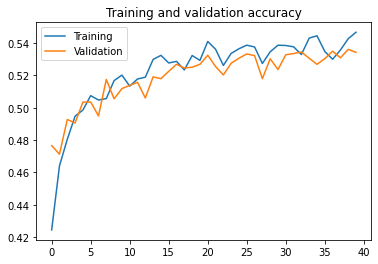

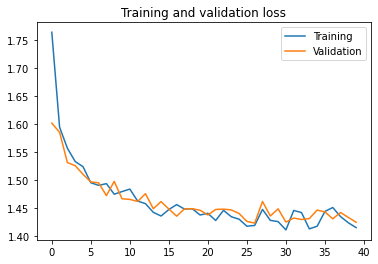

In [34]:
#Plot model

# Retrieve a list of list results on training and test data
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs   = range(len(acc))

#Plot training and validation (accuracy per epoch)
plt.plot(epochs, acc, label='Training')
plt.plot(epochs,val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#Plot training and validation (loss per epoch)
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.title('Training and validation loss')

In [35]:
#Predict model (test 100 data)
for i in range(100):
      probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
      predictions = probability_model.predict(X_validate)
      pred_name = [np.argmax(predictions[i])]
      print('Predicted:%s, Index:%s' % (predictions, pred_name))

Predicted:[[0.05826588 0.05745712 0.05746794 ... 0.05757257 0.05844466 0.05884673]
 [0.06032294 0.05713078 0.05713077 ... 0.05727494 0.05757912 0.05931571]
 [0.06704075 0.0577214  0.0577214  ... 0.05780666 0.05872523 0.05806105]
 ...
 [0.06114083 0.05758421 0.05758423 ... 0.12091644 0.0580761  0.05780565]
 [0.06897498 0.05786592 0.05786591 ... 0.0582187  0.05884124 0.05824748]
 [0.06548458 0.05768685 0.05768685 ... 0.05771308 0.05847388 0.05799134]], Index:[4]
Predicted:[[0.05826588 0.05745712 0.05746794 ... 0.05757257 0.05844466 0.05884673]
 [0.06032294 0.05713078 0.05713077 ... 0.05727494 0.05757912 0.05931571]
 [0.06704075 0.0577214  0.0577214  ... 0.05780666 0.05872523 0.05806105]
 ...
 [0.06114083 0.05758421 0.05758423 ... 0.12091644 0.0580761  0.05780565]
 [0.06897498 0.05786592 0.05786591 ... 0.0582187  0.05884124 0.05824748]
 [0.06548458 0.05768685 0.05768685 ... 0.05771308 0.05847388 0.05799134]], Index:[7]
Predicted:[[0.05826588 0.05745712 0.05746794 ... 0.05757257 0.05844466

**Save model to TensorFlow Lite model**

In [36]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path("./TF_model")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"model.tflite"
tflite_model_file.write_bytes(tflite_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"quant_model.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

!ls -lh {tflite_models_dir}

INFO:tensorflow:Assets written to: /tmp/tmpyx8mzjqe/assets
INFO:tensorflow:Assets written to: /tmp/tmpacqnsryg/assets


INFO:tensorflow:Assets written to: /tmp/tmpacqnsryg/assets


total 72K
-rw-r--r-- 1 root root 52K Jun  8 20:40 model.tflite
-rw-r--r-- 1 root root 17K Jun  8 20:40 quant_model.tflite
